<a href="https://colab.research.google.com/github/ucheokechukwu/ml_tensorflow_deeplearning/blob/main/07_milestone_project_1_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

Mixed precision training - uses both 16 and 32 bit types which makes it run faster during training.
Special hardware units called tensor cores.
Google colab offers:
K80 (not compatible)
P100 (not compatible)
Tesla T4 compatible


## Getting the helper functions
In past modules, we have helper functions that we import instead of re-writing the script.

In [1]:
# download helper function script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-03-05 20:46:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-03-05 20:46:04 (103 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# import series of helper functions for the notebook 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to download data
Tensorflow Datasets is a collection of ready-to-use datasets (already in Tensorflow format) with Tensorflow  or other Python ML frameworks. All datasets are exposed as `tf.data.Datasets`, enabling easy to use and high-performanc input pipelines.

https://www.tensorflow.org/datasets

Why use this?
- load data already in tensor format
- practice in well established datasets
- experiment with different modelling techniques on a consistent dataset

why not use this?
- datasets are static and do not change like real-world datasets

In [3]:
# Get tensorflow dataset
import tensorflow_datasets as tfds

In [4]:
# list all available datasets
datasets_list = tfds.list_builders() # get all available datasets in tfds
print("food101" in datasets_list) # is our target in the list of tfds

True


In [5]:
!nvidia-smi

Sun Mar  5 20:46:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

* note that this is a lot and takes a long time

In [6]:
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train","validation"],
                                             shuffle_files=True,
                                             as_supervised=True, #data gets returned in tuple format (data,label)
                                             with_info=True) #metadata is downloaded as well and saved into ds_info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteP6NPO1/food101-train.tfrecord*...:   0%|          …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteP6NPO1/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food1010 data from Tensorflow datasets

To become one with our data, we need to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels looks like (e.g. are they one-hot encoded or are they label encoded?)
* Do the labels match up with the class names?


In [7]:
# features of food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
# get the class names (we have to dig into the metadata ds_info)
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# get one sample of our training data (remember: start small and increase complexity)
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
train_one_sample = train_data.take(10)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# output info about our training sample
for image, label in train_one_sample:
  print(f"""
  image_shape: {image.shape}
  image_datatype: {image.dtype}
  target class from food101 (tensor form): {label}
  class name (str form): {class_names[label.numpy()]}
  """)


  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 1
  class name (str form): baby_back_ribs
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 23
  class name (str form): churros
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 24
  class name (str form): clam_chowder
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 4
  class name (str form): beef_tartare
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 2
  class name (str form): baklava
  

  image_shape: (512, 384, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor form): 58
  class name (str form): ice_cream
  

  image_shape: (512, 512, 3)
  image_datatype: <dtype: 'uint8'>
  target class from food101 (tensor f

In [12]:
import tensorflow as tf

In [13]:
# what does our image tensor look like?
image

<tf.Tensor: shape=(512, 384, 3), dtype=uint8, numpy=
array([[[ 16,  11,   5],
        [ 15,  10,   4],
        [ 14,   9,   3],
        ...,
        [  3,   4,   0],
        [  3,   4,   0],
        [  3,   4,   0]],

       [[ 15,  10,   4],
        [ 15,  10,   4],
        [ 16,  11,   5],
        ...,
        [  3,   4,   0],
        [  3,   4,   0],
        [  3,   4,   0]],

       [[ 15,  11,   2],
        [ 16,  12,   3],
        [ 17,  13,   4],
        ...,
        [  3,   4,   0],
        [  3,   4,   0],
        [  3,   4,   0]],

       ...,

       [[  7,   8,   0],
        [  7,   8,   0],
        [  7,   8,   0],
        ...,
        [115, 118,  91],
        [114, 117,  90],
        [113, 116,  89]],

       [[  7,   8,   0],
        [  7,   8,   0],
        [  7,   8,   0],
        ...,
        [114, 116,  92],
        [113, 115,  91],
        [112, 114,  90]],

       [[  5,   6,   0],
        [  5,   6,   0],
        [  5,   6,   0],
        ...,
        [112, 114,  9

In [14]:
# what are the min and max values of our image tensor?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Let's plot an image from our dataset

(-0.5, 383.5, 511.5, -0.5)

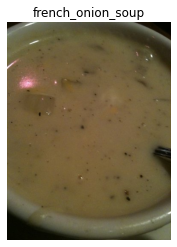

In [15]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to verify the label is associated with the right image
plt.axis(False)

## Create preprocessing functions for our data
Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).
However not all data comes like this.
In order to get it ready for a neural network, we have to write preprocessing functions and map it into your data.

What we know about our data
1. it's in uint8 datatype
2. it's comprised of all different sizes of image tensors
3. it's not scaled i.e. pixel values are 0-255 not 0-1.

what we know that models like:
1. data in `float32` dtype (or for mixed precision, `float16` and `float32`)
2. for batches, Tensorflow likes all the tensors within a batch to be all of the same sizes
3. scaled/normalized tensors always perform better

Therefore we have a framework for preprocessing function.

Since we're going to be using an `EfficientNetBX` pretrained model from `tf.keras.applications`, we don't need to rescale our data (these architectures have rescaling built in). 

This means our function needs to: 
1. reshape our images to all the same size
2. convert the dtype of our image tensors from uint8 to `float 32`

In [16]:
# make a functio for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  converts image dataype from 'unint8' -> 'float32' and
  reshapes image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape])
  # image = image/255 # resizing function but not required for EfficientNetX
  return tf.cast(image, tf.float32), label # return a tuple of float32 image and a label


In [17]:
# preprocess single sample miage and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"image before preprocessing: \n {image[:2]}...., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"image after preprocessing: \n {preprocessed_img[:2]}...., \nShape: {preprocessed_img.shape}, \nDataype: {preprocessed_img.dtype}")

image before preprocessing: 
 [[[16 11  5]
  [15 10  4]
  [14  9  3]
  ...
  [ 3  4  0]
  [ 3  4  0]
  [ 3  4  0]]

 [[15 10  4]
  [15 10  4]
  [16 11  5]
  ...
  [ 3  4  0]
  [ 3  4  0]
  [ 3  4  0]]]...., 
Shape: (512, 384, 3), 
Datatype: <dtype: 'uint8'>
image after preprocessing: 
 [[[15.229592  10.229592   4.229592 ]
  [15.285714  10.285714   4.285714 ]
  [15.285714  11.071428   2.714286 ]
  ...
  [ 3.         4.         0.       ]
  [ 3.         4.         0.       ]
  [ 3.         4.         0.       ]]

 [[15.954082  11.954082   2.2908163]
  [16.142857  12.142857   3.0102038]
  [17.071428  13.071428   3.6734686]
  ...
  [ 3.         4.         0.       ]
  [ 3.         4.         0.       ]
  [ 3.         4.         0.       ]]]...., 
Shape: (224, 224, 3), 
Dataype: <dtype: 'float32'>


## batch and prepare datasets
https://www.tensorflow.org/guide/data_performance (read the Best Practice Summary)






In [18]:
# map preprocessing function to training data and pararellize it
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# as this function runs, autotune means run this in parallel with all the available CPU
# shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE) #.shuffle(buffer_size=1000)
# how many elements to shuffle at a single time, determined by the amount of memory
# note that shuffling is redundant, we already did it before but we're repeating it here to be sure

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(tf.data.AUTOTUNE).cache()

In [19]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <CacheDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, Tensorflow, map this preprocessing function (`preprocess_img`) across our training dataset, then `shuffle` a number of elements and `batch` them together, and finally make sure you prepare new batches (`prefetch`) whilst the model is looking through (finding patterns) in the current batch"


## creating modelling callbacks
- callbacks are toold which add helpful functionality to models during training
1. Tensorboard callback
2. ModelCheckpoint callback

In [20]:
# creating tensorboard callback
from helper_functions import create_tensorboard_callback

In [21]:
# creating modelcheckpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_weights_only=True,
                                                      verbose=0,
                                                      save_best_only=True
)

## setup mixed precision training



In [22]:
# turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global policy to mixed precision

In [23]:
!nvidia-smi

Sun Mar  5 20:57:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    52W / 400W |    657MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
mixed_precision.global_policy()

<Policy "mixed_float16">

* Calculations are done in float16 and variables are stored in float32. So the outputs dtype has to be changed to float32 for numeric stability

## build feature extraction model

In [25]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [26]:
# create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# note that we separated the activation layer from the dense layer so that we can set the output to dtype float32

16705208/16705208 [==============================] - 2s 0us/step


In [27]:
# compile the model
# note that the label is in integer form not one hot encoded

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics="accuracy")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policy... are we using mixed precision

In [28]:
# Check layer dtype policy

for layer in model.layers:
  print (layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not?
* `layer.dtype`: is the datatype teh layer store stores variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [29]:
for layer in base_model.layers:
  print (layer.name, layer.trainable, layer.dtype, layer.dtype_policy)


input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [35]:
history = model.fit(train_data,
                    epochs=3,
                    steps_per_epoch = len(train_data),
                    validation_data=test_data,
                    validation_steps=0.15*len(test_data),
                    callbacks=[create_tensorboard_callback(dir_name="training_logs", experiment_name="efficientnetb0_101_all_data"), model_checkpoint
                                                 ])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_all_data/20230305-213359
Epoch 1/3
2366/2368 [============================>.] - ETA: 0s - loss: 0.9594 - accuracy: 0.7478

2368/2368 [==============================] - 40s 17ms/step - loss: 0.9597 - accuracy: 0.7478 - val_loss: 0.9723 - val_accuracy: 0.7335
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 0.8899 - accuracy: 0.7660

2368/2368 [==============================] - 42s 18ms/step - loss: 0.8899 - accuracy: 0.7660 - val_loss: 0.9702 - val_accuracy: 0.7342
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 0.8336 - accuracy: 0.7789

2368/2368 [==============================] - 41s 17ms/step - loss: 0.8337 - accuracy: 0.7789 - val_loss: 0.9584 - val_accuracy: 0.7300


In [31]:
results=model.evaluate(test_data)

790/790 [==============================] - 18s 23ms/step - loss: 1.0008 - accuracy: 0.7288


## Challenge: 
Complete the template version of 07 to obtain a computer vision model building off the one that was built in this notebook to beat the DeepFood papaer


##TODO: Save the whole model to file

In [37]:
# # Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)

# model.save("/content/drive/MyDrive/ML_Tensor/deepfoodvision.hdf5")
# # Load model previously saved above
# loaded_model=tf.keras.models.load_model("/content/drive/MyDrive/ML_Tensor/deepfoodvision.hdf5")

In [38]:
# Check the layers in the base model and see what dtype policy they're using
# Check loaded model performance (this should be the same as results_feature_extract_model)
model_loaded = model
results_0 = model_loaded.evaluate(test_data)

790/790 [==============================] - 11s 14ms/step - loss: 0.9750 - accuracy: 0.7317


## TODO: Preparing our model's layers for fine-tuning
Next: Fine-tune the feature extraction model to beat the DeepFood paper.

Like all good cooking shows, I've saved a model I prepared earlier (the feature extraction model from above) to Google Storage.

You can download it to make sure you're using the same model as originall trained going forward.

In [39]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2023-03-05 21:37:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  9.30MB/s    in 1.7s    

2023-03-05 21:37:22 (9.30 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [40]:
# make a new directory and unzip the downloaded model there

!mkdir downloaded_gs_model
!unzip /content/07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  /content/07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [41]:
# Load and evaluate downloaded GS model
gs_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")
results_gs = gs_model.evaluate(test_data)

790/790 [==============================] - 15s 16ms/step - loss: 1.0881 - accuracy: 0.7067


In [42]:
# Get a summary of the downloaded model
gs_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [43]:
# How does the loaded model perform? (evaluate it on the test dataset)
results_gs


[1.0880963802337646, 0.7066534757614136]

In [44]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in gs_model.layers:
  layer.trainable = True


In [45]:
for layer in gs_model.layers:
  print(layer.name, layer.trainable, layer.dtype)

input_layer True float32
efficientnetb0 True float32
pooling_layer True float32
dense True float32
softmax_float32 True float32


In [47]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more


early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           mode='auto',
                                                           patience=3)

# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = "Checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    save_best_only=True)

In [49]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate

gs_model.compile(loss="sparse_categorical_crossentropy",
                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                 metrics="accuracy")


In [50]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE

history_gs = model.fit(train_data,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data = test_data,
                       validation_steps=int(0.15 * len(test_data)),
                       callbacks= [create_tensorboard_callback(dir_name="tensorboard", experiment_name="Deeplearning_by_self"),
                                   checkpoint_callback,
                                   early_stopping_callback])

Saving TensorBoard log files to: tensorboard/Deeplearning_by_self/20230305-215622
Epoch 1/100
2368/2368 [==============================] - 41s 17ms/step - loss: 0.7865 - accuracy: 0.7930 - val_loss: 0.9655 - val_accuracy: 0.7323
Epoch 2/100
2368/2368 [==============================] - 41s 17ms/step - loss: 0.7477 - accuracy: 0.8018 - val_loss: 0.9748 - val_accuracy: 0.7288
Epoch 3/100
2368/2368 [==============================] - 41s 17ms/step - loss: 0.7130 - accuracy: 0.8120 - val_loss: 0.9756 - val_accuracy: 0.7293
Epoch 4/100
2368/2368 [==============================] - 42s 18ms/step - loss: 0.6837 - accuracy: 0.8191 - val_loss: 0.9866 - val_accuracy: 0.7291


In [52]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
# model.save("/content/drive/MyDrive/ML_Tensor/deepfood_by_me")
# model.save("/content/drive/MyDrive/ML_Tensor/deepfood_by_me.hdf5")


TypeError: ignored

In [ ]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_gs_tuning = gs_model.evaluate(test_data)

## TODO: View training results on TensorBoard
To do: Upload and view your model's training results to TensorBoard.dev and view them.

See https://tensorboard.dev/ for more.

In [53]:
!tensorboard dev upload --logdir /content/tensorboard/Deeplearning_by_self \
--name "Food101 Deep Learning by Self Experiments" \
--description "Deep learning experiments on the Food101 dataset using transfer learning from EfficienetNetB and tensorflow datasets" \
--one_shot

2023-03-05 22:05:51.852436: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-05 22:05:51.852533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-05 22:05:51.852550: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/tensorboard/Deeplearning_

In [ ]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

## TODO: Evaluate your trained model
Some ideas you might want to go through:

Find the precision, recall and f1 scores for each class (all 101).
Build a confusion matrix for each of the classes.
Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).